In [1]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import tweepy
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kbandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kbandi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [3]:
#Twitter credentials for the app
consumer_key = 'jHfw1Qq9z8ymMEiIInTlQX9S3'
consumer_secret = 'e51wxpEWlWpE0RrF2eAAAV6G8Ge1rMowRQ2xyQuXIrGC8qmoWB'
access_key= '949890691269718017-lDbaxoxnsW0kp0XYhY2bJ7iczqosD26'
access_secret = 'nCDO7z3ukTamOkXPdtLdbs45zSw5y9FPSUWoV9nJyeEy4'

In [4]:
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [5]:
#declare file paths as follows
test_tweets = "D:/Capstone project/Capstone_NLP_Kranthi/data/extract_tweet_data.csv"

In [6]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
'favorite_count', 'retweet_count', 'original_author',   'possibly_sensitive', 'hashtags',
'user_mentions', 'place', 'place_coord_boundaries']

In [7]:
# Handle Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [8]:
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [9]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [10]:
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [11]:
#clean the tweets
def clean_tweets(tweet):
 
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
#after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
#replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
#remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
#filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
#looping through conditions
    for w in word_tokens:
#check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)return tweet

In [12]:
# define the date range to extract the tweets 

start_date = '2019-01-01'
end_date = '2019-07-28'

In [13]:
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
 
 
           #tweepy preprocessing called for basic preprocessing
            clean_text = status['text']
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
 
            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])
 
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
 
            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [14]:
#Declare Keywords
keyword = '#Jio OR jio OR Jio OR JIO'

In [15]:
#Call our method
write_tweets(keyword, test_tweets)

In [16]:
train = pd.read_csv("D:/Capstone project/Capstone_NLP_Kranthi/data/extract_tweet_data.csv")

In [57]:
train.head(10)

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,tidy_tweet,label
0,1155524467918962688,Sun Jul 28 17:04:36 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Worst connectivity in last 2 days..#Jio,Worst connectivity last 2 days.. Jio,"Sentiment(polarity=-0.5, subjectivity=0.533333...",-0.5000,0.5333333333333333,en,0,0,halbe_h,NaN,Jio,NaN,NaN,NaN,worst connect last day,1
1,1155521708775919616,Sun Jul 28 16:53:38 +0000 2019,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@Idea no free caller tune like #Jio jio\r\nHat...,Idea free caller tune like Jio jio Hate u idea...,"Sentiment(polarity=0.0, subjectivity=0.8333333...",0.0000,0.8333333333333334,en,1,0,KaranSinghRT1,NaN,Jio,Idea,Jamshedpur,NaN,idea free caller tune like hate idea atleast g...,1
2,1155520540272017408,Sun Jul 28 16:48:59 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Very disappointed bye #JIO network is still n...,Very disappointed bye JIO network still workin...,"Sentiment(polarity=-0.6875, subjectivity=0.887...",-0.6875,0.8875000000000001,en,0,0,sa_gurii,NaN,JIO,NaN,INDIA,NaN,veri disappoint network still work even time b...,0
3,1155512669731844102,Sun Jul 28 16:17:43 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",@reliancejio #jio network is third class netwo...,reliancejio jio network third class network I ...,"Sentiment(polarity=0.0, subjectivity=0.1222222...",0.0000,0.12222222222222222,en,0,0,akshaypatnijain,NaN,jio,reliancejio,NaN,NaN,reliancejio network third class network use la...,1
4,1155505745703526407,Sun Jul 28 15:50:12 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @ameetvmehta: Under Guidance of Acharya Gur...,RT ameetvmehta Under Guidance Acharya Guru Shr...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,en,0,6,renu_hansraj,NaN,NayePadmaSagar,ameetvmehta,Mumbai,NaN,ameetvmehta under guidanc acharya guru shri na...,1
5,1155503563117756417,Sun Jul 28 15:41:32 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @ameetvmehta: Under Guidance of Acharya Gur...,RT ameetvmehta Under Guidance Acharya Guru Shr...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,en,0,6,ijagdishMange,NaN,NayePadmaSagar,ameetvmehta,"Mumbai, India",NaN,ameetvmehta under guidanc acharya guru shri na...,1
6,1155500405339521025,Sun Jul 28 15:28:59 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",itna slow internet chalega to kon jio me ru...,itna slow internet chalega kon jio rukega want...,"Sentiment(polarity=-0.65, subjectivity=0.7)",-0.6500,0.7,en,0,0,Mmhasannn,NaN,Jio,NaN,"Kanpur, India",NaN,itna slow internet chalega rukega want port ne...,0
7,1155497715024793600,Sun Jul 28 15:18:18 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",@JioCare @reliancejio @ Everyday Same Problem ...,JioCare reliancejio Everyday Same Problem acti...,"Sentiment(polarity=-0.275, subjectivity=0.45625)",-0.2750,0.45625,en,0,0,abhiagrawal2610,False,"Jio, TRAI","JioCare, reliancejio, TRAI",NaN,NaN,jiocar reliancejio everyday same problem actio...,1
8,1155496227779174400,Sun Jul 28 15:12:23 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",@reliancejio @JioCare No or very very slow in...,reliancejio JioCare No slow internet Rcity mal...,"Sentiment(polarity=0.15000000000000002, subjec...",0.1500,0.39999999999999997,en,0,0,nirajgosalia,NaN,NaN,"reliancejio, JioCare, airtelindia",NaN,NaN,reliancejio jiocar slow internet rciti mall gh...,1
9,1155495939349442560,Sun Jul 28 15:11:14 +0000 2019,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#Vodafone used to be the biggest mobile servic...,Vodafone used biggest mobile service provider ...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,en,0,0,garykim,False,"Vodafone, Jio, ipcarrier, feedly",NaN,"Denver, CO and Reston VA",NaN,vodafon use bigg

In [59]:
train.shape

(11724, 19)

In [23]:
train['polarity']= train.polarity.convert_objects(convert_numeric=True).dropna()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [26]:
train['label'] = np.where(train['polarity']<= -0.6,0,1)

In [27]:
train.head()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,tidy_tweet,label
0,1155524467918962688,Sun Jul 28 17:04:36 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Worst connectivity in last 2 days..#Jio,Worst connectivity last 2 days.. Jio,"Sentiment(polarity=-0.5, subjectivity=0.533333...",-0.5000,0.5333333333333333,en,0,0,halbe_h,NaN,Jio,NaN,NaN,NaN,Worst connectivity last days,1
1,1155521708775919616,Sun Jul 28 16:53:38 +0000 2019,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@Idea no free caller tune like #Jio jio\r\nHat...,Idea free caller tune like Jio jio Hate u idea...,"Sentiment(polarity=0.0, subjectivity=0.8333333...",0.0000,0.8333333333333334,en,1,0,KaranSinghRT1,NaN,Jio,Idea,Jamshedpur,NaN,Idea free caller tune like Hate idea atleast g...,1
2,1155520540272017408,Sun Jul 28 16:48:59 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Very disappointed bye #JIO network is still n...,Very disappointed bye JIO network still workin...,"Sentiment(polarity=-0.6875, subjectivity=0.887...",-0.6875,0.8875000000000001,en,0,0,sa_gurii,NaN,JIO,NaN,INDIA,NaN,Very disappointed network still working evenin...,0
3,1155512669731844102,Sun Jul 28 16:17:43 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",@reliancejio #jio network is third class netwo...,reliancejio jio network third class network I ...,"Sentiment(polarity=0.0, subjectivity=0.1222222...",0.0000,0.12222222222222222,en,0,0,akshaypatnijain,NaN,jio,reliancejio,NaN,NaN,reliancejio network third class network using ...,1
4,1155505745703526407,Sun Jul 28 15:50:12 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @ameetvmehta: Under Guidance of Acharya Gur...,RT ameetvmehta Under Guidance Acharya Guru Shr...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,en,0,6,renu_hansraj,NaN,NayePadmaSagar,ameetvmehta,Mumbai,NaN,ameetvmehta Under Guidance Acharya Guru Shri N...,1


In [28]:
def remove_pattern(input_txt, pattern): 
    r = re.findall(pattern, input_txt) 
    for i in r: 
        input_txt = re.sub(i, '', input_txt) 
    return input_txt

In [29]:
#--Creating column tidy tweet with text after cleaning --#
    
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['clean_text'], "@[\w]*") 

#--remove special characters, numbers, punctuations--#
train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

#--Removing short words--#
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) 
train.head()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,tidy_tweet,label
0,1155524467918962688,Sun Jul 28 17:04:36 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Worst connectivity in last 2 days..#Jio,Worst connectivity last 2 days.. Jio,"Sentiment(polarity=-0.5, subjectivity=0.533333...",-0.5000,0.5333333333333333,en,0,0,halbe_h,NaN,Jio,NaN,NaN,NaN,Worst connectivity last days,1
1,1155521708775919616,Sun Jul 28 16:53:38 +0000 2019,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@Idea no free caller tune like #Jio jio\r\nHat...,Idea free caller tune like Jio jio Hate u idea...,"Sentiment(polarity=0.0, subjectivity=0.8333333...",0.0000,0.8333333333333334,en,1,0,KaranSinghRT1,NaN,Jio,Idea,Jamshedpur,NaN,Idea free caller tune like Hate idea atleast g...,1
2,1155520540272017408,Sun Jul 28 16:48:59 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",Very disappointed bye #JIO network is still n...,Very disappointed bye JIO network still workin...,"Sentiment(polarity=-0.6875, subjectivity=0.887...",-0.6875,0.8875000000000001,en,0,0,sa_gurii,NaN,JIO,NaN,INDIA,NaN,Very disappointed network still working evenin...,0
3,1155512669731844102,Sun Jul 28 16:17:43 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",@reliancejio #jio network is third class netwo...,reliancejio jio network third class network I ...,"Sentiment(polarity=0.0, subjectivity=0.1222222...",0.0000,0.12222222222222222,en,0,0,akshaypatnijain,NaN,jio,reliancejio,NaN,NaN,reliancejio network third class network using ...,1
4,1155505745703526407,Sun Jul 28 15:50:12 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @ameetvmehta: Under Guidance of Acharya Gur...,RT ameetvmehta Under Guidance Acharya Guru Shr...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,en,0,6,renu_hansraj,NaN,NayePadmaSagar,ameetvmehta,Mumbai,NaN,ameetvmehta Under Guidance Acharya Guru Shri N...,1


In [30]:
#--Tokenization(splitting a string of text into tokens)--#
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split()) 
tokenized_tweet.head() 

0                    [Worst, connectivity, last, days]
1    [Idea, free, caller, tune, like, Hate, idea, a...
2    [Very, disappointed, network, still, working, ...
3    [reliancejio, network, third, class, network, ...
4    [ameetvmehta, Under, Guidance, Acharya, Guru, ...
Name: tidy_tweet, dtype: object

In [31]:
#Stemming(stripping the suffixes)
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming 
tokenized_tweet.head() 

0                          [worst, connect, last, day]
1    [idea, free, caller, tune, like, hate, idea, a...
2    [veri, disappoint, network, still, work, even,...
3    [reliancejio, network, third, class, network, ...
4    [ameetvmehta, under, guidanc, acharya, guru, s...
Name: tidy_tweet, dtype: object

In [32]:
#--Stitching tokens back together--#
for i in range(len(tokenized_tweet)): 
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) 
train['tidy_tweet'] = tokenized_tweet 

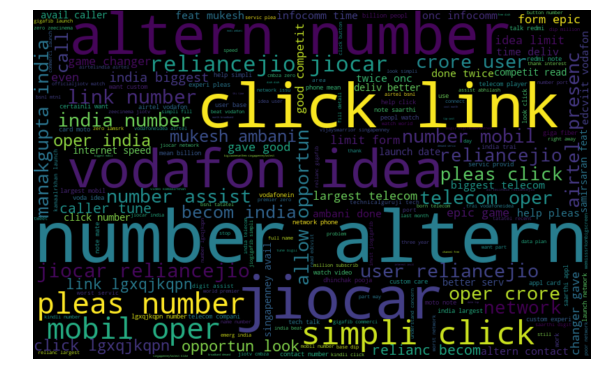

In [33]:
####STORY GENERATION AND VISUALIZATION FROM TWEETS####
#Understanding common words used in tweets: Wordcloud
all_words = ' '.join([text for text in train['tidy_tweet']]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

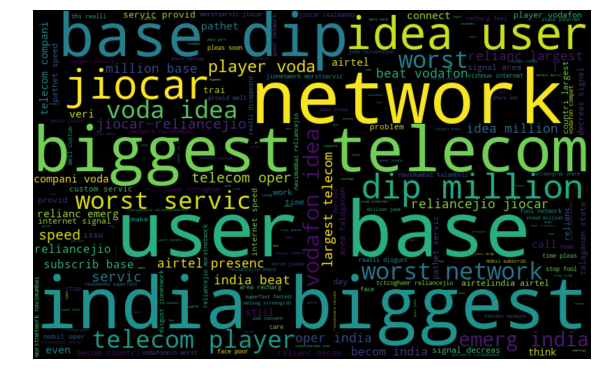

In [34]:
#--Words in non-hate tweets--#
normal_words =' '.join([text for text in train['tidy_tweet'][train['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show() 

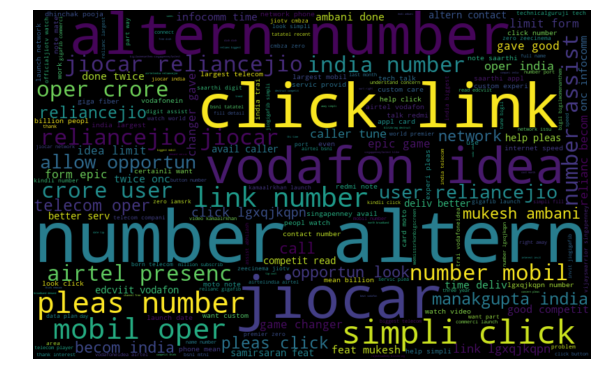

In [35]:
#--Words in hate tweets--#
negative_words = ' '.join([text for text in train['tidy_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [36]:
#--Impact of hashtags on tweets --#

#--function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags



In [37]:
#--extracting hashtags from non hate tweets

HT_regular = hashtag_extract(train['tidy_tweet'][train['label'] == 0])

In [38]:
#--extracting hashtags from hate tweets
HT_negative = hashtag_extract(train['tidy_tweet'][train['label'] == 1])

In [39]:
#--unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [45]:
### -- Building Model ----# 
#-- Extracting Features from clean tweets---#
#-- Count Vectors---#

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train['tidy_tweet'])


In [47]:
#--TF-IDF Features--#

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(train['tidy_tweet'])

In [55]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

In [56]:
# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.9867060561299853